In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load and configure aesthetics
df = pd.read_csv('ai_environmental_data.csv')
sns.set_theme(style="whitegrid")

In [3]:
# Derive ratios for carbon efficiency and cooling demand
df['GCF'] = df['Carbon_CO2e_kg'] / df['Energy_kWh']
df['WII'] = df['Water_Usage_L'] / df['Energy_kWh']

train_df = df[df['Phase'] == 'Training'].copy()
inf_df = df[df['Phase'] == 'Inference'].copy()

# --- Univariate Analysis ---
s1_total_energy = train_df['Energy_kWh'].sum()
s2_avg_carbon = train_df['Carbon_CO2e_kg'].mean()
s3_pue_dispersion = train_df['PUE'].std()
s4_inf_median = inf_df['Energy_kWh'].median()
s5_inf_iqr = inf_df['Energy_kWh'].quantile(0.75) - inf_df['Energy_kWh'].quantile(0.25)
s6_train_water_total = train_df['Water_Usage_L'].sum()
s7_inf_water_avg = inf_df['Water_Usage_L'].mean()
s8_max_grid_intensity = df['Grid_Intensity_gCO2'].max()

# --- Bivariate & LSE Analysis ---
s9_cor_ew = df['Energy_kWh'].corr(df['Water_Usage_L'])
s10_cor_ec = df['Energy_kWh'].corr(df['Carbon_CO2e_kg'])
s11_avg_wii = df['WII'].mean()
s12_avg_gcf = df['GCF'].mean()

# Least Squares Estimation
slope_w, intercept_w, r_w, p_w, std_err_w = stats.linregress(df['Energy_kWh'], df['Water_Usage_L'])
slope_c, intercept_c, r_c, p_c, std_err_c = stats.linregress(df['Energy_kWh'], df['Carbon_CO2e_kg'])

# Comparative Efficiency
bloom_c = train_df.loc[train_df['Model_Name'] == 'BLOOM', 'Carbon_CO2e_kg'].values[0]
palm_c = train_df.loc[train_df['Model_Name'] == 'PaLM', 'Carbon_CO2e_kg'].values[0]
s16_bloom_gain = (1 - (bloom_c / palm_c)) * 100

# Display Statistical Summary
audit_results = {
    "Total Training Energy": s1_total_energy, "PUE Std Dev": s3_pue_dispersion,
    "Inf Median Energy": s4_inf_median, "Inf Energy IQR": s5_inf_iqr,
    "Water-Energy Corr": s9_cor_ew, "Carbon-Energy Corr": s10_cor_ec,
    "Avg WII (L/kWh)": s11_avg_wii, "Water LSE Slope": slope_w,
    "Carbon LSE Slope": slope_c, "BLOOM Carbon Savings (%)": s16_bloom_gain
}
pd.Series(audit_results)

Total Training Energy       7.202000e+06
PUE Std Dev                 4.856267e-02
Inf Median Energy           4.466674e-04
Inf Energy IQR              5.870745e-04
Water-Energy Corr           1.000000e+00
Carbon-Energy Corr          9.914632e-01
Avg WII (L/kWh)             1.900000e+00
Water LSE Slope             1.900000e+00
Carbon LSE Slope            3.979780e-01
BLOOM Carbon Savings (%)    9.811440e+01
dtype: float64

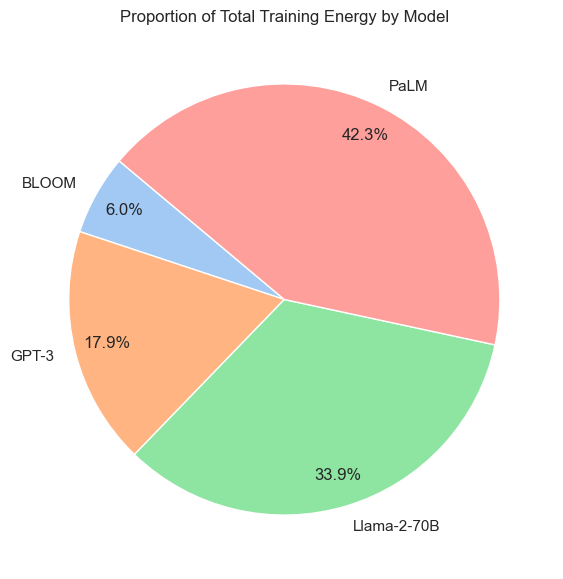

In [4]:
plt.figure(figsize=(7, 7))
shares = train_df.groupby('Model_Name')['Energy_kWh'].sum()
plt.pie(shares, labels=shares.index, autopct='%1.1f%%', 
        colors=sns.color_palette('pastel'), startangle=140, pctdistance=0.85)
plt.title('Proportion of Total Training Energy by Model')
plt.show()

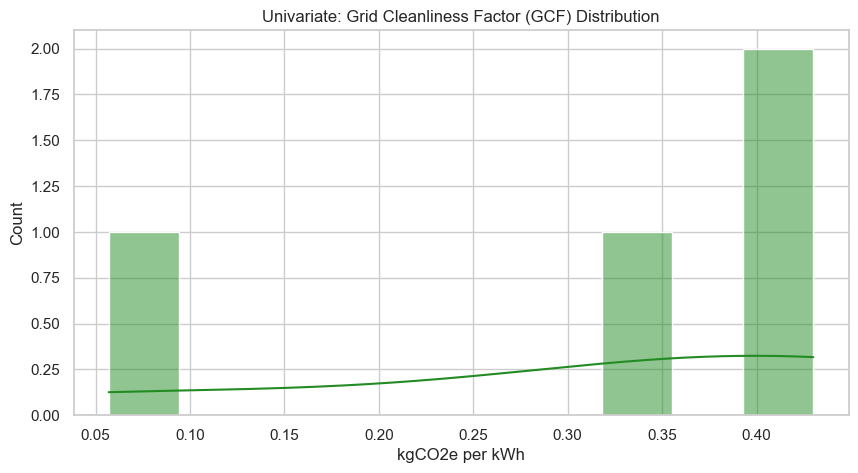

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['GCF'], bins=10, kde=True, color='forestgreen')
plt.title('Univariate: Grid Cleanliness Factor (GCF) Distribution')
plt.xlabel('kgCO2e per kWh')
plt.show()

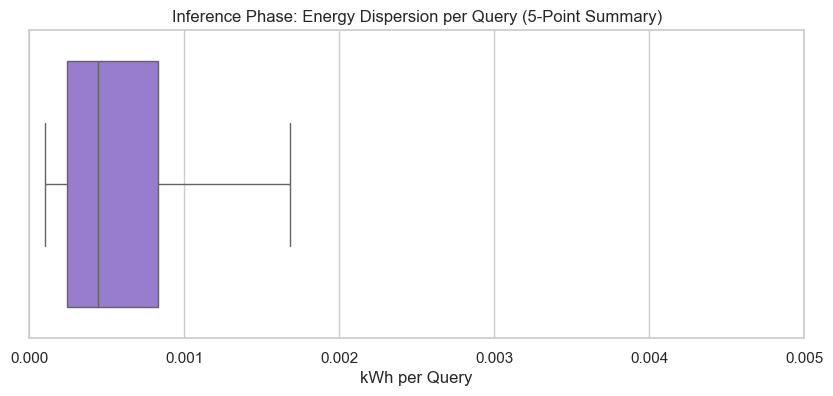

In [6]:
plt.figure(figsize=(10, 4))
# Standard whis=1.5 provides the classic 5-point summary
sns.boxplot(data=inf_df, x='Energy_kWh', orient='h', color='mediumpurple', showfliers=False)
plt.xlim(0, 0.005)
plt.title('Inference Phase: Energy Dispersion per Query (5-Point Summary)')
plt.xlabel('kWh per Query')
plt.show()

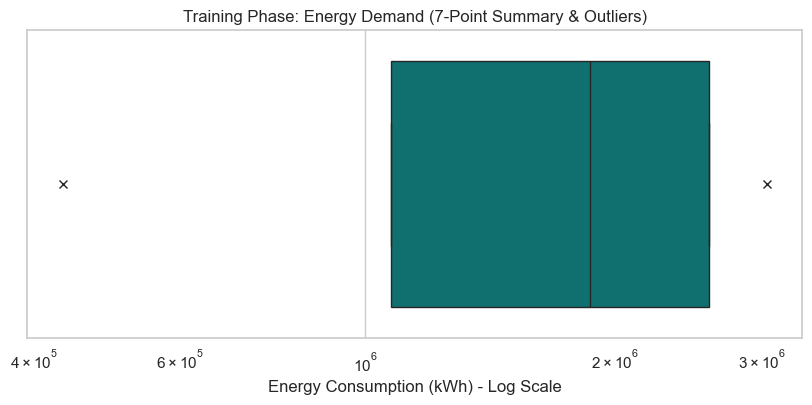

In [7]:
plt.figure(figsize=(10, 4))
# Whiskers set to [2, 98] create the 7-point summary (Min, 2%, Q1, Median, Q3, 98%, Max)
sns.boxplot(data=train_df, x='Energy_kWh', orient='h', whis=[2, 98], 
            color='teal', flierprops={"marker": "x", "markerfacecolor": "red"})
plt.xscale('log')
plt.title('Training Phase: Energy Demand (7-Point Summary & Outliers)')
plt.xlabel('Energy Consumption (kWh) - Log Scale')
plt.show()

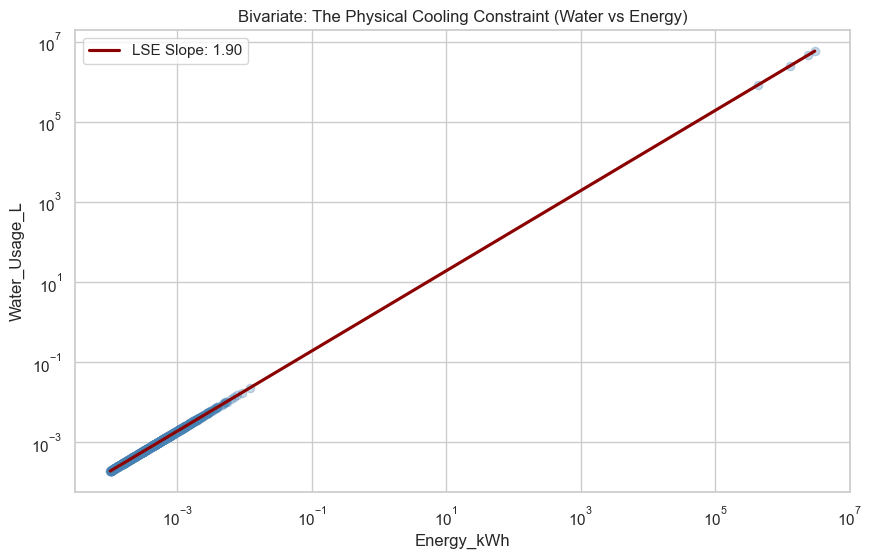

In [8]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Energy_kWh', y='Water_Usage_L', 
            scatter_kws={'alpha':0.3, 'color':'steelblue'}, 
            line_kws={'color':'darkred', 'label': f'LSE Slope: {slope_w:.2f}'})
plt.xscale('log')
plt.yscale('log')
plt.title('Bivariate: The Physical Cooling Constraint (Water vs Energy)')
plt.legend()
plt.show()

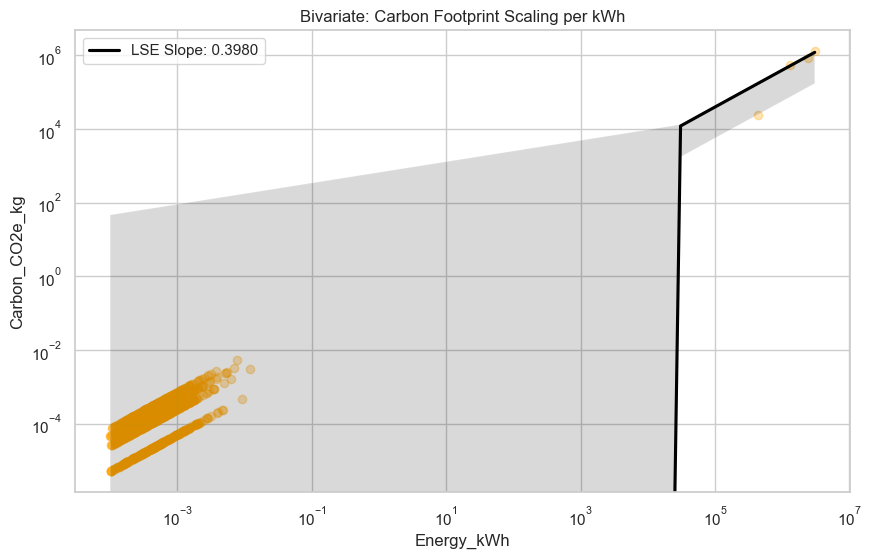

In [9]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Energy_kWh', y='Carbon_CO2e_kg', 
            scatter_kws={'alpha':0.3, 'color':'orange'}, 
            line_kws={'color':'black', 'label': f'LSE Slope: {slope_c:.4f}'})
plt.xscale('log')
plt.yscale('log')
plt.title('Bivariate: Carbon Footprint Scaling per kWh')
plt.legend()
plt.show()